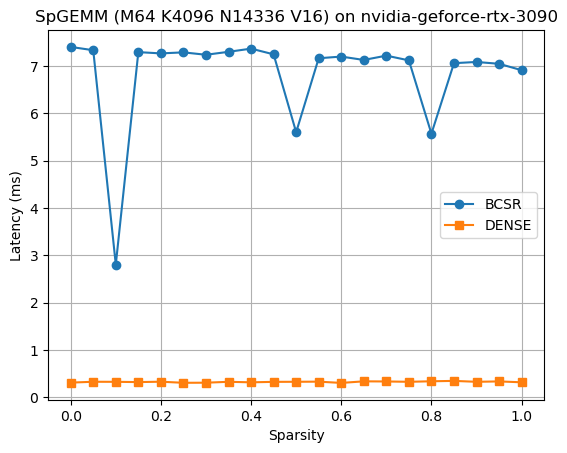

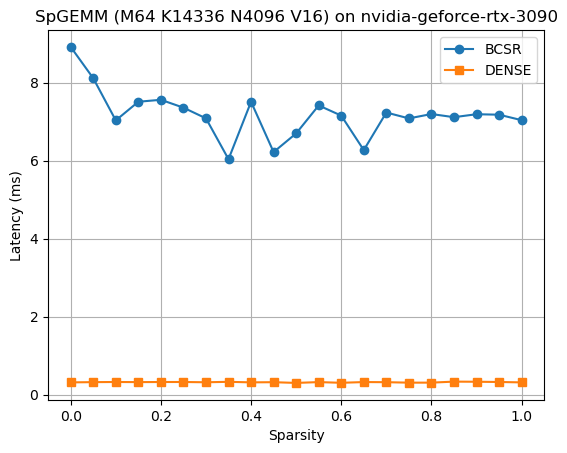

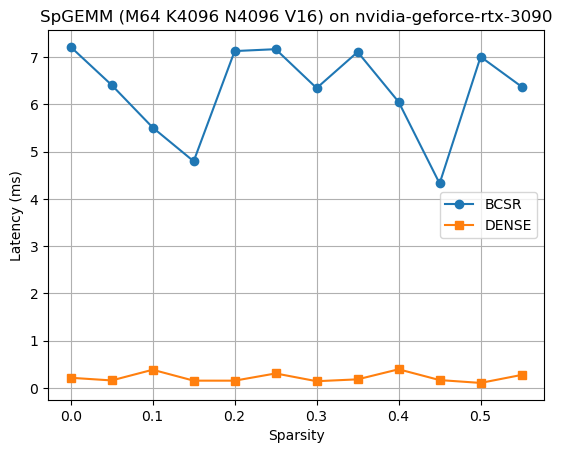

In [2]:
import glob
import torch
import re
import matplotlib.pyplot as plt

def get_arch():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device.type == 'cuda':
        props = torch.cuda.get_device_properties(device)
        return props.name.lower().replace(" ", "-")
    else:
        return "cpu"

arch = get_arch()

pattern = re.compile(r"kernel-results-b(\d+)-e(\d+)-h(\d+)-b(\d+)\.txt")

for filename in glob.glob("./sbatch-results/kernel-results-*.txt"):
    match = pattern.search(filename)
    if not match:
        # If the filename doesn't match the pattern, skip
        continue
    
    M, K, N, V = match.groups()
    M = int(M)
    K = int(K)
    N = int(N)
    V = int(V)
    
    sparsities = []
    bcsr_latencies = []
    dense_latencies = []
    
    # Read the file and parse values
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            # Each line format: SPARSITY=X    GEMM_{BCSR or DENSE}=Y
            parts = line.split()
            if len(parts) != 2:
                continue
            sparsity_str = parts[0].split('=')[1]
            latency_parts = parts[1].split('=')
            gemm_type = latency_parts[0].split('_')[1]  # BCSR or DENSE
            latency_val = float(latency_parts[1])
            
            sparsity_val = float(sparsity_str)
            
            if gemm_type == "BCSR":
                if sparsity_val not in sparsities:
                    sparsities.append(sparsity_val)
                    bcsr_latencies.append(latency_val)
                    dense_latencies.append(None)
                else:
                    idx = sparsities.index(sparsity_val)
                    bcsr_latencies[idx] = latency_val
            elif gemm_type == "DENSE":
                if sparsity_val not in sparsities:
                    sparsities.append(sparsity_val)
                    bcsr_latencies.append(None)
                    dense_latencies.append(latency_val)
                else:
                    idx = sparsities.index(sparsity_val)
                    dense_latencies[idx] = latency_val
    
    # Filter out incomplete pairs
    combined = [(s, b, d) for (s, b, d) in zip(sparsities, bcsr_latencies, dense_latencies) if b is not None and d is not None]
    combined.sort(key=lambda x: x[0])
    if not combined:
        continue
    
    sparsities = [c[0] for c in combined]
    bcsr_latencies = [c[1] for c in combined]
    dense_latencies = [c[2] for c in combined]
    
    # Plot the figure
    plt.figure()
    plt.plot(sparsities, bcsr_latencies, marker='o', label='BCSR')
    plt.plot(sparsities, dense_latencies, marker='s', label='DENSE')
    plt.xlabel('Sparsity')
    plt.ylabel('Latency (ms)')
    plt.title(f"SpGEMM (M{M} K{K} N{N} V{V}) on {arch}")
    plt.legend()
    plt.grid(True)
    plt.show()
